## Image Classification in PyTorch

We would use this notebook to understand the basics of Image Classification

In [1]:
%matplotlib inline

In [2]:
import torch                      # import PyTorch library
import torch.nn as nn             # import PyTorch's neural network module
import torch.nn.functional as F   # import PyTorch's functional interface to neural network operations
import torchvision                # import PyTorch's computer vision library
import numpy as np                # import NumPy library for numerical computing
import os                         # import os module for interacting with the file system
from torchvision import transforms  # import PyTorch's module for image transforms
from tqdm import tqdm            # import tqdm module for progress bars
import torchvision.transforms.functional as TF  # import PyTorch's module for functional image transforms
from PIL import Image             # import Python Imaging Library for image manipulation

In [3]:
from torch import optim

In [4]:
import matplotlib.pyplot as plt

In [5]:
print(torch.__version__)
print(torchvision.__version__)
print(np.__version__)

1.12.1+cu113
0.13.1+cu113
1.24.3


We would check if we have a GPU hardware available on our machine

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
!nvidia-smi

Wed May 10 10:56:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:2F:00.0 Off |                    0 |
|  0%   45C    P0    59W / 300W |      2MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
x = torch.randn(4)
x.cuda()

tensor([ 0.2807, -0.6294, -1.5649, -0.9692], device='cuda:0')

We would train a Convolution Neural Network on the CIFAR10 Dataset, which consists of 60000 32x32 px colour images in 10 classes.

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The CIFAR10 dataset is inbuilt in PyTorch and can be called using

In [10]:
from torchvision.datasets import CIFAR10

We need to transform the images to tensor so that it can be passed through a neural network. 

In [11]:
trainset = CIFAR10(root='./data', train=True,  download=True, transform=transforms.ToTensor())
testset  = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


We utilize the PyTorch Data Loading which calls the dataset in batches.

In [12]:
from torch.utils.data import DataLoader

`torch.utils.data.DataLoader` is a PyTorch class that provides an interface for loading data from a dataset. It is typically used for loading data in batches during the training or testing of a neural network. The DataLoader class takes several parameters:

`dataset`: the dataset to load the data from. This can be any dataset that implements the torch.utils.data.Dataset class, such as torchvision.datasets.ImageFolder or a custom dataset.

`batch_size`: the number of samples to load in each batch. This parameter determines the size of the mini-batches used during training. Larger batch sizes can result in faster training times, but may also require more memory.

`shuffle`: a boolean indicating whether to shuffle the order of the samples in the dataset before loading them. This can be useful for reducing bias in the training process and improving model performance.

`num_workers`: the number of worker threads to use for loading the data in parallel. This can speed up the data loading process, especially for larger datasets.

In [13]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True,  num_workers=2)
testloader  = DataLoader(testset,  batch_size=4, shuffle=False, num_workers=2)

### Visualizing the dataset

We would visualize a few images from the dataset

In [14]:
images, labels = next(iter(trainloader))

In [15]:
images.shape

torch.Size([4, 3, 32, 32])

In [16]:
labels

tensor([7, 2, 3, 6])

In [17]:
new_im = Image.new('RGB', (images.size(0)*100, 100))

x_offset = 0
for i in range(images.size(0)):
    img = TF.to_pil_image(images[i]).resize((100,100))
    new_im.paste(img, (x_offset,0))
    x_offset += 100

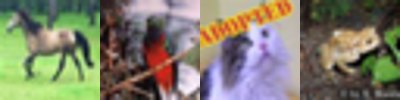

['horse', 'bird', 'cat', 'frog']


In [18]:
display(new_im)
print([classes[i] for i in labels])

### Defining our Neural Network

We would now design a Neural Network that has the following architecture.

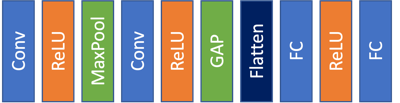

In [19]:
img = Image.open('architecture.png')
w,h = img.size
img = img.resize((400, int((h/w)*400)))
display(img)

This is a PyTorch neural network model class called `Classifier` that extends the `nn.Module` class. It is a simple CNN-based image classification model that takes a 3-channel input image, applies a sequence of convolutional and fully-connected layers to produce an output vector of length 10, representing the class probabilities.

In detail, the `__init__` method defines the architecture of the neural network as a `nn.Sequential` object. The layers in this sequence are:

- `nn.Conv2d(3, 512, 3, 1, 1)`: a 2D convolutional layer that takes 3 input channels, applies 512 output channels with a kernel size of 3 and stride of 1, and uses padding of 1 to maintain the same spatial size of the feature maps.
- `nn.ReLU(True)`: a rectified linear unit (ReLU) activation function that applies element-wise non-linearity to the output of the previous convolutional layer.
- `nn.MaxPool2d(2, 2)`: a 2D max-pooling layer that halves the spatial size of the feature maps.
- `nn.Conv2d(512, 256, 3, 1, 1)`: another 2D convolutional layer that takes 512 input channels, applies 256 output channels with a kernel size of 3 and stride of 1, and uses padding of 1 to maintain the same spatial size of the feature maps.
- `nn.ReLU(True)`: another ReLU activation function.
- `nn.AdaptiveAvgPool2d(1)`: a global average pooling layer that averages the feature maps over their spatial dimensions to produce a 1x1 feature map for each channel.
- `nn.Flatten()`: a flatten layer that flattens the 1x1 feature maps into a 1D tensor.
- `nn.Linear(256, 128)`: a fully-connected linear layer that takes the flattened feature vector and applies a linear transformation with 256 input features and 128 output features.
- `nn.ReLU(True)`: another ReLU activation function.
- `nn.Linear(128, 10)`: a final fully-connected linear layer that takes the output of the previous layer and applies a linear transformation with 128 input features and 10 output features, corresponding to the number of output classes.

The `forward` method takes an input tensor `x` and applies the network layers defined in `self.network` to produce an output tensor `y`. The output tensor represents the predicted class probabilities for the input image.

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(nn.Conv2d(3, 512, 3, 1, 1),
                                     nn.ReLU(True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(512, 256, 3, 1, 1),
                                     nn.ReLU(True),
                                     nn.AdaptiveAvgPool2d(1),
                                     nn.Flatten(),
                                     nn.Linear(256, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 10))

    def forward(self, x):
        y = self.network(x)
        return y

We create an instance of the `Classifier` class and assign it to the variable `model` using the default constructor. Then, we generate a random input tensor `x` with shape `(1, 3, 224, 224)` using the `torch.randn` function. This tensor represents a random RGB image with a resolution of `224x224` pixels.

The input tensor `x` is then passed through the model by calling the `forward` method of the model object with `x` as the input argument. The output tensor `y` represents the predicted class probabilities for the input image, with shape `(1, 10)`.

Finally, the we print the shape of the output tensor `y` using the `shape` attribute. The output shape `(1, 10)` indicates the class probabilities for the input image and has assigned a probability to each of the 10 output classes.

In [21]:
model = Classifier()
x = torch.randn(1,3,224,224)
y = model(x)
print(y.shape)

torch.Size([1, 10])


If we have a GPU, we take our model to it.

In [22]:
model.to(device)

Classifier(
  (network): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AdaptiveAvgPool2d(output_size=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

We define two important components for training the neural network model:

1. `nn.CrossEntropyLoss()`: This is a loss function that is commonly used for classification problems. It combines the softmax activation function and the negative log likelihood loss into a single function, making it easier to compute both the probabilities of the output classes and the corresponding loss. The `nn.CrossEntropyLoss` instance is created with the default parameters and assigned to the variable `criterion`.
2. `optim.SGD(model.parameters(), lr=0.001, momentum=0.9)`: This is an optimization algorithm called stochastic gradient descent (SGD) with momentum. It is used to update the weights of the neural network during training. The `optim.SGD` function takes two arguments: the first argument is the parameters that need to be optimized, which in this case are the parameters of the `model` instance, accessed using the `model.parameters()` method. The second argument is a dictionary of hyperparameters that control the learning rate (`lr`) and momentum (`momentum`) of the optimizer. The learning rate controls how much the weights are updated in each step, while the momentum controls the degree to which the optimizer considers the previous updates while making the current update. The resulting optimizer object is assigned to the variable `optimizer`.

Note that the `.to(device)` method call after `nn.CrossEntropyLoss()` is used to move the criterion to the device (CPU or GPU) specified by the `device` variable. Similarly, the `optimizer` is automatically moved to the device where the model is located, when `model.parameters()` is called.

In [23]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
### Training our model

In [25]:
# Create an empty list to store the training loss for each epoch
losses = []

model.train()

# Iterate over the specified number of epochs
for epoch in range(2):
    # Initialize a running loss counter for the current epoch
    running_loss = 0.0
    # Iterate over the training dataset one batch at a time
    for i, data in enumerate(trainloader, 0):
        # Load a batch of input images and their corresponding labels
        inputs, labels = data
        # Move the inputs and labels to the device specified by `device`
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Reset the optimizer's gradients to zero
        optimizer.zero_grad()
        # Use the model to predict the output probabilities for the input images
        outputs = model(inputs)
        # Calculate the loss between the predicted probabilities and the true labels
        loss = criterion(outputs, labels)
        # Backpropagate the loss to compute the gradients of the model parameters
        loss.backward()
        # Use the optimizer to update the model parameters based on the computed gradients
        optimizer.step()
        # Update the running loss counter for the current epoch
        running_loss += loss.item()
        # Print the current average loss every 2000 batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            # Append the current average loss to the list of losses for this epoch
            losses.append(running_loss / 2000)
            # Reset the running loss counter
            running_loss = 0.0

# Print a message indicating that training has finished
print('Finished Training')

[1,  2000] loss: 2.242
[1,  4000] loss: 2.114
[1,  6000] loss: 2.045
[1,  8000] loss: 1.985
[1, 10000] loss: 1.922
[1, 12000] loss: 1.892
[2,  2000] loss: 1.842
[2,  4000] loss: 1.802
[2,  6000] loss: 1.751
[2,  8000] loss: 1.740
[2, 10000] loss: 1.716
[2, 12000] loss: 1.703
Finished Training


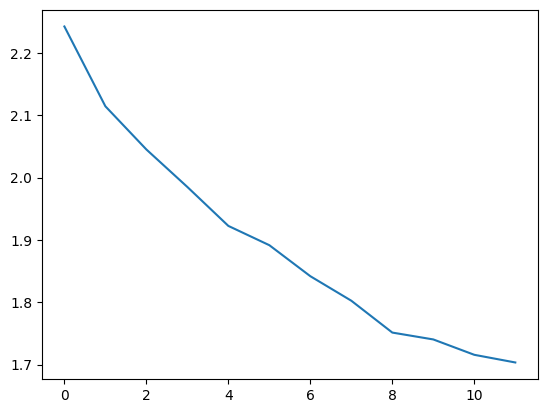

In [26]:
plt.plot(losses)

### Testing our model

In [27]:
# Create dictionaries to store the number of correctly predicted and total predictions for each class in the test dataset
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Initialize counters for the overall number of correct predictions and the total number of predictions made
correct = 0
total = 0

model.eval()

# Disable gradient computation to save memory and speed up computation during evaluation
with torch.no_grad():
    # Iterate over the test dataset one batch at a time
    for data in testloader:
        # Load a batch of input images and their corresponding labels
        inputs, labels = data
        # Move the inputs and labels to the device specified by `device`
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Use the model to predict the output probabilities for the input images
        outputs = model(inputs)
        # Find the index of the class with the highest probability in each output vector
        _, predictions = torch.max(outputs, 1)
        # Increment the counters for the overall number of correct predictions and the total number of predictions made
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        # Iterate over each label-prediction pair in the current batch
        for label, prediction in zip(labels, predictions):
            # Increment the number of correct predictions for the corresponding class in `correct_pred` if the label and prediction match
            if label == prediction:
                correct_pred[classes[label]] += 1
            # Increment the total number of predictions for the corresponding class in `total_pred` regardless of whether the prediction is correct or not
            total_pred[classes[label]] += 1

In [28]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print("-----------------------------------")
print(f'Accuracy for class: total is {100 * correct // total} %')

Accuracy for class: plane is 36.1 %
Accuracy for class: car   is 35.3 %
Accuracy for class: bird  is 14.2 %
Accuracy for class: cat   is 19.6 %
Accuracy for class: deer  is 47.3 %
Accuracy for class: dog   is 37.0 %
Accuracy for class: frog  is 36.9 %
Accuracy for class: horse is 41.5 %
Accuracy for class: ship  is 68.6 %
Accuracy for class: truck is 38.8 %
-----------------------------------
Accuracy for class: total is 37 %


### Finetuning ResNet model

We would load a pre-trained ResNet18 model and fine-tunes it on our 10-class classification task.

Import the pre-trained ResNet18 model architecture from the `torchvision.models` module.

In [29]:
from torchvision.models import resnet18

Instantiate the ResNet18 model and load the pre-trained weights using the `pretrained=True` argument. This initializes the model with weights learned on the ImageNet dataset.

In [30]:
model = resnet18(pretrained=True)

/h/aditya/miniconda3/envs/pytorch110/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/h/aditya/miniconda3/envs/pytorch110/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The shape of the output tensor is (1, 1000), representing the 1000-class output of the pre-trained model.

In [31]:
x = torch.randn(1,3,224,224)
y = model(x)
print(y.shape)

torch.Size([1, 1000])


Replace the fully connected layer (model.fc) of the ResNet18 model with a new linear layer (nn.Linear) that has 10 output features, since we want to use the model for a 10-class classification task.

In [32]:
model.fc = nn.Linear(model.fc.in_features, 10)

The shape of the output tensor is now (1, 10), representing the 10-class output of the fine-tuned model.

In [33]:
x = torch.randn(1,3,224,224)
y = model(x)
print(y.shape)

torch.Size([1, 10])


In [34]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We define a data transformation pipeline using the `transforms.Compose()` method from the `torchvision.transforms` module. This pipeline consists of two transformations applied sequentially to an input image:

1. `transforms.ToTensor()`: This converts the input image, which is a PIL image or numpy ndarray, into a PyTorch tensor. The image is first converted to a tensor of shape (C x H x W), where C is the number of channels (3 for color images) and H and W are the height and width of the image, respectively. The pixel values are also scaled from the range [0, 255] to the range [0, 1].
2. `transforms.Normalize()`: This normalizes the tensor image with the specified mean and standard deviation. The normalization formula used is `(input - mean) / std`. The mean and standard deviation values used in this transformation are `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`, respectively. These values are the mean and standard deviation of the RGB channels across a large dataset of images (specifically, the ImageNet dataset). Normalization is a common preprocessing step for deep learning models because it helps the model converge faster and generalize better.

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
trainset = CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True,  num_workers=8)
testloader  = DataLoader(testset,  batch_size=4, shuffle=False, num_workers=2)

In [37]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
model.train()
for epoch in range(4):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 1.529
[1,    40] loss: 1.026
[1,    60] loss: 0.876
[1,    80] loss: 0.826
[1,   100] loss: 0.767
[1,   120] loss: 0.744
[1,   140] loss: 0.682
[1,   160] loss: 0.721
[1,   180] loss: 0.657
[2,    20] loss: 0.538
[2,    40] loss: 0.522
[2,    60] loss: 0.532
[2,    80] loss: 0.514
[2,   100] loss: 0.522
[2,   120] loss: 0.537
[2,   140] loss: 0.504
[2,   160] loss: 0.528
[2,   180] loss: 0.534
[3,    20] loss: 0.360
[3,    40] loss: 0.385
[3,    60] loss: 0.368
[3,    80] loss: 0.395
[3,   100] loss: 0.379
[3,   120] loss: 0.422
[3,   140] loss: 0.427
[3,   160] loss: 0.407
[3,   180] loss: 0.399
[4,    20] loss: 0.299
[4,    40] loss: 0.292
[4,    60] loss: 0.288
[4,    80] loss: 0.286
[4,   100] loss: 0.315
[4,   120] loss: 0.287
[4,   140] loss: 0.304
[4,   160] loss: 0.329
[4,   180] loss: 0.314
Finished Training


In [39]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [40]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print("-----------------------------------")
print(f'Accuracy for class: total is {100 * correct // total} %')

Accuracy for class: plane is 80.5 %
Accuracy for class: car   is 82.2 %
Accuracy for class: bird  is 81.1 %
Accuracy for class: cat   is 76.5 %
Accuracy for class: deer  is 73.8 %
Accuracy for class: dog   is 60.7 %
Accuracy for class: frog  is 87.3 %
Accuracy for class: horse is 80.5 %
Accuracy for class: ship  is 95.3 %
Accuracy for class: truck is 88.9 %
-----------------------------------
Accuracy for class: total is 80 %


### Evaluating the performance on own images

We can also check the model performance on our own images. We download a plane image.

In [41]:
# !wget https://e3.365dm.com/21/07/2048x1152/skynews-boeing-737-plane_5435020.jpg

We load the image and resize it to 32x32 which was used by our model during training.

In [42]:
img = Image.open('skynews-boeing-737-plane_5435020.jpg')
im1 = img.resize((32,32))
im2 = img.resize((100,100))

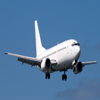

In [43]:
display(im2)

Applying the transformations defined in the `transform` variable to the resized image `im1` and assigning the result to `im1T`.

In [44]:
im1T = transform(im1)

In [45]:
im1T.shape

torch.Size([3, 32, 32])

Adding a batch dimension to the image tensor `im1T` using the `unsqueeze()` method.

In [46]:
im1T = im1T.unsqueeze(0)

In [47]:
im1T.shape

torch.Size([1, 3, 32, 32])

In [48]:
model.eval()
with torch.no_grad():    # deactivate autograd engine to reduce memory usage and speed up computations
    im1T = im1T.to(device)    # send the input tensor to the device (CPU or GPU)
    outputs = model(im1T)    # feed the input tensor to the model to get the output tensor

In [49]:
idx = torch.max(outputs, 1)[1].item()    # get the index of the class with maximum probability from the output tensor

In [50]:
print(classes[idx])    # print the name of the predicted class corresponding to the index

plane
